In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.5 MB/s eta 0:00:00


In [3]:
import os

home = '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/PIQA/'

imroot = home+'merged_images'
os.chdir(home)

In [4]:
prefix = 'piqa'

In [5]:
import json
import ast
datalen = 0
dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "piqa", "license": {}, "data_subtype": prefix, "questions": [] }

with open(home+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  global datalen
  datalen = len(data)
  for i in data[0:int(datalen*0.8)]:
    ijson = json.loads(i)
    imlist = ast.literal_eval(ijson['images'])
    #print(imlist)
    anslist = ast.literal_eval(ijson['answer_choices'])
    try:
      #print(len(anslist))
      assert len(anslist) == 2
    except:
      print(i)
    im1 = imlist[0].lstrip('./images/').rstrip('.png')
    im2 = imlist[1].lstrip('./images/')
    dumpdict['questions'].append( { "image_id": imroot+"/Merged_"+im1+"#"+im2, "question": ijson['question']+" "+ijson['passage'], "question_id": ijson['qid'], "answer_choices": anslist, "answer_id": int(ijson['answer']) } )

with open('/content/'+prefix+'_train.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

355
{'info': {}, 'task_type': 'Open-Ended', 'data_type': 'piqa', 'license': {}, 'data_subtype': 'piqa', 'questions': [{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/PIQA/merged_images/Merged_piqa1#piqa2.png', 'question': "Select an image from the following choices that can fill-in-the-blank provide in the passage.  How do I ready a guinea pig cage for it's new occupants? Provide the guinea pig with a cage full of a few inches of bedding made of ripped ___, you will also need to supply it with a water bottle and a food dish.", 'question_id': 1611, 'answer_choices': ['Image [0]', 'Image [1]'], 'answer_id': 0}, {'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/PIQA/merged_images/Merged_piqa3#piqa4.png', 'question': 'Select an image from the following choices that can fill-in-the-blank provide in the passage.  Make outdoor pillow. Blow into ___ can and tie with rubber band.', 'question_id': 1612, 'answer_choices': ['Image [0]', 'Image [1]'], 'answer_id': 1}, 

In [6]:
import json
f = open('/content/'+prefix+'_train.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 284


In [7]:
questions[0]

{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/PIQA/merged_images/Merged_piqa1#piqa2.png',
 'question': "Select an image from the following choices that can fill-in-the-blank provide in the passage.  How do I ready a guinea pig cage for it's new occupants? Provide the guinea pig with a cage full of a few inches of bedding made of ripped ___, you will also need to supply it with a water bottle and a food dish.",
 'question_id': 1611,
 'answer_choices': ['Image [0]', 'Image [1]'],
 'answer_id': 0}

In [8]:
from os import listdir
from os.path import isfile, join

file_names = [f for f in listdir(imroot) if isfile(join(imroot, f))]
print(file_names)
print(len(file_names))

['Merged_piqa1#piqa2.png', 'Merged_piqa7#piqa8.png', 'Merged_piqa5#piqa6.png', 'Merged_piqa9#piqa10.png', 'Merged_piqa3#piqa4.png', 'Merged_piqa11#piqa12.png', 'Merged_piqa13#piqa14.png', 'Merged_piqa15#piqa16.png', 'Merged_piqa17#piqa18.png', 'Merged_piqa21#piqa22.png', 'Merged_piqa19#piqa20.png', 'Merged_piqa25#piqa26.png', 'Merged_piqa23#piqa24.png', 'Merged_piqa31#piqa32.png', 'Merged_piqa29#piqa30.png', 'Merged_piqa27#piqa28.png', 'Merged_piqa35#piqa36.png', 'Merged_piqa33#piqa34.png', 'Merged_piqa37#piqa38.png', 'Merged_piqa41#piqa42.png', 'Merged_piqa39#piqa40.png', 'Merged_piqa43#piqa44.png', 'Merged_piqa45#piqa46.png', 'Merged_piqa47#piqa48.png', 'Merged_piqa51#piqa52.png', 'Merged_piqa49#piqa50.png', 'Merged_piqa55#piqa56.png', 'Merged_piqa53#piqa54.png', 'Merged_piqa57#piqa58.png', 'Merged_piqa59#piqa60.png', 'Merged_piqa63#piqa64.png', 'Merged_piqa65#piqa66.png', 'Merged_piqa61#piqa62.png', 'Merged_piqa69#piqa70.png', 'Merged_piqa67#piqa68.png', 'Merged_piqa73#piqa74.png', 

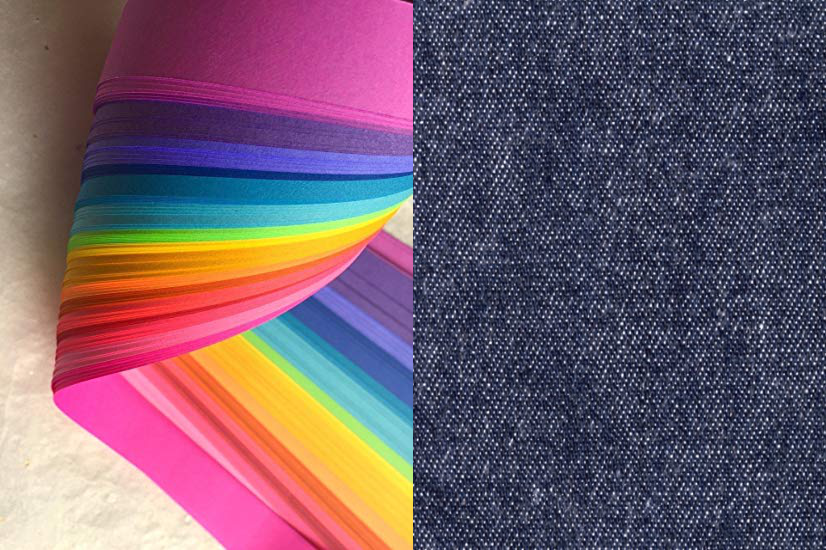

In [9]:
from PIL import Image

path = questions[0]['image_id']
image = Image.open(path)
image

In [10]:
import torch
import torchvision
from PIL import Image
import torch.nn.functional as F
from torch import ones, long as lg, float as fl
import torchvision.transforms as transforms

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, processor):
        self.questions = questions
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        questions = self.questions[idx]
        image = Image.open(questions['image_id']).convert("RGB")
        resize_transform = transforms.Resize((384, 384))
        image = resize_transform(image)
        text = questions['question']
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")

        encoding['visual_embeds'] = encoding['pixel_values']
        encoding['visual_embeds'] = encoding['visual_embeds'][:,0,:,:]
        encoding.pop('pixel_values')
        encoding.pop('pixel_mask')
        encoding['visual_token_type_ids'] = ones(encoding['visual_embeds'].shape[:-1], dtype=lg)
        encoding['visual_attention_mask'] = ones(encoding['visual_embeds'].shape[:-1], dtype=fl)

        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        targets = torch.zeros(len(questions['answer_choices']))
        targets[questions['answer_id']] = 1.0
        encoding["labels"] = targets
        return encoding

In [11]:
from transformers import ViltProcessor
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
dataset = VQADataset(questions=questions,processor=processor)

In [13]:
dataset[0]

{'input_ids': tensor([  101,  7276,  2019,  3746,  2013,  1996,  2206,  9804,  2008,  2064,
         6039,  1011,  1999,  1011,  1996,  1011,  8744,  3073,  1999,  1996,
         6019,  1012,  2129,  2079,  1045,  3201,  1037,  7102, 10369,  7980,
         2005,  2009,  1005,  1055,  2047, 18837,  1029,  3073,  1996,   102]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'visual_embeds': tensor([[ 0.0667,  0.0745,  0.0353,  ..., -0.5843, -0.1137, -0.4039],
        [ 0.0275,  0.0510,  0.0510,  ..., -0.5922, -0.6471, -0.6078],
        [ 0.0039,  0.0196,  0.0510,  ..., -0.3255, -0.5843, -0.6000],
        ...,
        [ 0.9765,  0.9686,  0.9294,  ..., -0.7098, -0.6471, -0.3490],
        [ 0.9608,  0.9765,  0.9373,  ..., -0.6314,

In [14]:
dataset[1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'visual_embeds', 'visual_token_type_ids', 'visual_attention_mask', 'labels'])

In [15]:
processor.decode(dataset[0]['input_ids'])

"[CLS] select an image from the following choices that can fill - in - the - blank provide in the passage. how do i ready a guinea pig cage for it ' s new occupants? provide the [SEP]"

In [16]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()
labels

0

In [17]:
from transformers import VisualBertForQuestionAnswering
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisualBertForQuestionAnswering.from_pretrained("daki97/visualbert_finetuned_easy_vqa", num_labels=2,ignore_mismatched_sizes=True, visual_embedding_dim = 384)
model.to(device)

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

Some weights of VisualBertForQuestionAnswering were not initialized from the model checkpoint at daki97/visualbert_finetuned_easy_vqa and are newly initialized because the shapes did not match:
- cls.weight: found shape torch.Size([13, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls.bias: found shape torch.Size([13]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisualBertForQuestionAnswering(
  (visual_bert): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=384, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
  

In [18]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import ones, long as lg, float as fl,  stack, FloatTensor

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  visual_embeds = [item['visual_embeds'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  visual_token_type_ids = [item['visual_token_type_ids'] for item in batch]
  visual_attention_mask = [item['visual_attention_mask'] for item in batch]
  labels = [item['labels'] for item in batch]

  batch = {}
  batch['visual_embeds'] = torch.stack(visual_embeds)
  batch['input_ids'] = torch.stack(input_ids)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['visual_token_type_ids'] = torch.stack(visual_token_type_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['visual_attention_mask'] = torch.stack(visual_attention_mask)
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

In [19]:
batch = next(iter(train_dataloader))

In [20]:
for k,v in batch.items():
  print(k, v.shape)

visual_embeds torch.Size([1, 384, 384])
input_ids torch.Size([1, 40])
token_type_ids torch.Size([1, 40])
visual_token_type_ids torch.Size([1, 384])
attention_mask torch.Size([1, 40])
visual_attention_mask torch.Size([1, 384])
labels torch.Size([1, 2])


In [21]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# -- CHANGE BASED ON HOW MANY EPOCHS YOU WANT TO RUN FOR
e = 5

model.train()
for epoch in range(e):
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        batch = {k:v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        #print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/284 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/284 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/284 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/284 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/284 [00:00<?, ?it/s]

## Inference

In [22]:
import json
import ast
datalen = 0
dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "piqa", "license": {}, "data_subtype": prefix, "questions": [] }

with open(home+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  global datalen
  datalen = len(data)
  for i in data[int(datalen*0.8):datalen]:
    test_ijson = json.loads(i)
    test_imlist = ast.literal_eval(test_ijson['images'])
    #print(test_imlist)
    test_anslist = ast.literal_eval(test_ijson['answer_choices'])
    try:
      #print(len(anslist))
      assert len(test_anslist) == 2
    except:
      print(i)
    im1 = test_imlist[0].lstrip('./images/').rstrip('.png')
    im2 = test_imlist[1].lstrip('./images/')
    dumpdict['questions'].append( { "image_id": imroot+"/Merged_"+im1+"#"+im2, "question": test_ijson['question']+" "+test_ijson['passage'], "question_id": test_ijson['qid'], "answer_choices": test_anslist, "answer_id": int(test_ijson['answer']) } )

with open('/content/'+prefix+'_test.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

355
{'info': {}, 'task_type': 'Open-Ended', 'data_type': 'piqa', 'license': {}, 'data_subtype': 'piqa', 'questions': [{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/PIQA/merged_images/Merged_piqa569#piqa570.png', 'question': 'Select an image from the following choices that can fill-in-the-blank provide in the passage.  How long do you need to wait until the glue gun heats up? Give the gun 3 minutes to ___ down up, and then squeeze the trigger to check if the glue is flowing.', 'question_id': 1895, 'answer_choices': ['Image [0]', 'Image [1]'], 'answer_id': 1}, {'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/PIQA/merged_images/Merged_piqa571#piqa572.png', 'question': 'Select an image from the following choices that can fill-in-the-blank provide in the passage.  heater warming ___ easily', 'question_id': 1896, 'answer_choices': ['Image [0]', 'Image [1]'], 'answer_id': 0}, {'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/PIQA/merged_images/Me

In [23]:
import json
f = open('/content/'+prefix+'_test.jsonl','r')
test_data_questions = json.load(f)
test_questions = test_data_questions['questions']

print(test_data_questions.keys())
print("Number of questions:", len(test_questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 71


In [24]:
test_dataset = VQADataset(questions=test_questions,processor=processor)

In [25]:
len(test_dataset)

71

# Single Instance Inference

In [26]:
exid = 1
example = test_dataset[exid]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'visual_embeds', 'visual_token_type_ids', 'visual_attention_mask', 'labels'])


In [27]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [28]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", predicted_class)
print("Ground-truth answer:", test_dataset[exid]['labels'].argmax(-1).item())

Predicted answer: 0
Ground-truth answer: 0


# Batch Inference

In [29]:
import csv
filprefix = prefix+"_result"

count = 0
st = 0
end = datalen-int(datalen*0.8)
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end):
    correctness = 0
    example = test_dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = test_dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])